# Building graph tests
In this notebook, we compare some building graphs methods. We compare 4 methods :
- Gather per tumour type
- Gather per KMeans clusters
- Gather per Spectral clustering clusters
- Gather per Hierarchical clustering clusters

The tests we use in this notebook are the following :
- Print the connected patients features, to see if the connections are biologically realistic.
- Print the number of distinct sub graphs : indeed, if there are too many sub graphs, the patients will not really be associated with others.
- Print the number of neighbours per node : indeed, beyond 4 neighbors, there is no really interest, we don't gain more information.

Instead of creating the networkx graph, we use the adjacency matrix to determine the measures.

# Table of contents

0. [Reading and preprocessing](#0-reading-preprocessing)
1. [Building graphs](#building-graphs)
    1. [Gather per tumour type](#1-gather-per-tumour-type)
    2. [Gather per KMeans clusters](#2-gather-per-kmeans-clusters)
    3. [Gather per Spectral clustering clusters](#3-gather-per-spectral-clustering-clusters)
    4. [Gather per Hierarchical clustering clusters](#4-gather-per-hierarchical-clustering-clusters)
2. [Print connected patients](#print-connected-patients)
3. [Print number of distinct sub graphs](#print-n-subgraphs)
4. [Print number of neighbours per node](#print-n-neighbours)

In [1]:
import pandas as pd
from models.BuildGraph import BuildGraph
import numpy as np
import networkx as nx
from sklearn.cluster import KMeans, SpectralClustering, AgglomerativeClustering
import matplotlib.pyplot as plt

## 0. Reading and preprocessing
We read the data from the following article : , and we do drop the non naive patients, and the censored patients (ie the patients with status = 0 but time_event < time_we_look_at)

In [2]:
df = pd.read_excel('data/Supplemental-table1.xlsx')

# Delete non naive patients
df = df.loc[df["Cohort"] == "Naive"]

df

,Anonymous ID,EGA ID,Tumour type,Sex,Line of therapy,Immunotherapy regimen,Cohort,Reason for discontinuation,Best response,Age at advanced disease diagnosis,...,Alive_0,Time to progression (days),Progression_1,Clinical benefit,CD8+ T cell score,Exome mut per mb,Genome mut per mb,CD274 expression,M1M2 expression,Lymph related
0,14891,EGAD00001001961,LUNG,F,8,Nivolumab,Naive,Progression,Mixed,45,...,1,179,1,NCB,0.351869,11.095310,23.0729,4.1689,55.51575,Non-lymph related
1,18624,EGAD00001002047,AECA,F,10,Nivolumab,Naive,Progression,Stable disease,47,...,1,148,1,NCB,0.071464,3.876336,5.4552,0.7910,9.32352,Non-lymph related
2,21392,EGAD00001002544,OV,F,6,Monalizumab,Naive,Progression,Physician assessed SD,57,...,1,79,1,NCB,0.040394,2.415688,4.1274,4.0377,50.12008,Lymph related
3,21516,EGAD00001002546,SKCM,F,3,Ipilimumab,Naive,Death,Not evaluable,29,...,1,11,0,NCB,0.052774,6.235845,11.4871,0.6006,1.58550,Non-lymph related
4,22186,EGAD00001001966,LUNG,F,4,Atezolizumab,Naive,Progression,Stable disease,52,...,1,80,1,NCB,0.009323,4.606660,7.1503,1.8234,38.42695,Non-lymph related
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92,39280,EGAD00001004933,LUNG,M,2,Pembrolizumab,Naive,Toxicity,Physician Assessed SD,60,...,1,401,0,DCB,0.695396,84.998501,96.4079,8.4768,86.62561,Non-lymph related
94,37899,EGAD00001005838,CHOL,F,2,Nivolumab,Naive,Death,Physician assessed PR,38,...,1,96,0,NCB,0.818233,2.247151,2.7416,11.2704,47.97376,Non-lymph related
95,37775,EGAD00001004934,HNSC,M,1,Avelumab/OX40 agonist PF-04518600,Naive,Progression,Stable disease,69,...,1,69,1,NCB,0.018982,3.848247,5.8036,8.7136,5.13403,Non-lymph related
96,38313,EGAD00001005844,ACC,F,3,Avelumab/Debio1143 (SMAC mimetic),Naive,Toxicity,Partial response,34,...,1,51,1,NCB,0.000000,5.617878,7.7940,0.0688,0.51364,Non-lymph related


In [3]:
def drop_censored_patients(df: pd.DataFrame, status_name: str, time_name: str, t: float)->pd.DataFrame:
    """ 
    Delete censored patients from the initial dataframe. A censored patient is a patient with status = 0 and time_event < t.

    ### Parameters :
    - df : the dataframe to update
    - status_name : the name of the status event column in the dataframe
    - time_name : the name of the time event column in the dataframe
    - t : the time when we look at (threshold).

    ### Returns :
    The dataframe without censored patients.
    """

    # Get index of to drop patients
    to_drop = df.index[np.where((df[status_name] == 0) & (df[time_name]<t))[0]]
    print(to_drop)
    print(f"{to_drop.shape[0]} censored patients deleted")

    # Update dataframe
    df_non_censored = df.drop(to_drop,axis=0)

    return df_non_censored

In [4]:
## TTP (Time To Progression)
t_ttp = np.median(df["Time to progression (days)"].to_numpy())
df_ttp_non_censored = drop_censored_patients(df, "Progression_1", "Time to progression (days)", t_ttp)

## OS (Overall survival)
t_os = np.median(df["Overall survival (days)"].to_numpy())
df_os_non_censored = drop_censored_patients(df, "Alive_0", "Overall survival (days)", t_os)

Index([3, 9, 56, 72, 78, 85], dtype='int64')
6 censored patients deleted
Index([10], dtype='int64')
1 censored patients deleted


## 1. Building graphs <a name="building-graphs"></a>

### 1. Gather per tumour type

In [5]:
## TTP :
build_graph_tumour_type_ttp = BuildGraph(df_ttp_non_censored)

## OS :
build_graph_tumour_type_os = BuildGraph(df_os_non_censored)

#### Extract tumour type column

In [6]:
## TTP :
tumour_type_ttp = df_ttp_non_censored["Tumour type"].to_numpy()

## OS :
tumour_type_os = df_os_non_censored["Tumour type"].to_numpy()

#### Compute adjacency matrix

In [7]:
## TTP :
build_graph_tumour_type_ttp.compute_adjacency_matrix(tumour_type_ttp)

# OS :
build_graph_tumour_type_os.compute_adjacency_matrix(tumour_type_os)

#### Create graph

In [8]:
def create_graph(df, A):

    # Initialize with empty graph
    G = nx.Graph()
    
    # Add nodes, with its features
    for i in range(A.shape[0]):
        G.add_nodes_from([(i,{"x":df.iloc[[i],:]})])

    # Add edges
    rows, cols = np.where(A == 1)
    edges = zip(rows.tolist(), cols.tolist())
    G.add_edges_from(edges)

    return G

In [9]:
## TTP :
G_tumour_type_ttp = create_graph(df_ttp_non_censored, build_graph_tumour_type_ttp.A)

## OS :
G_tumour_type_os = create_graph(df_os_non_censored, build_graph_tumour_type_os.A)

### 2. Gather per KMeans clusters

In [10]:
## TTP :
build_graph_kmeans_ttp = BuildGraph(df_ttp_non_censored)

## OS :
build_graph_kmeans_os = BuildGraph(df_os_non_censored)

#### Apply clustering


In [11]:
features_clustering = ["Tumour type","Sex","Age at advanced disease diagnosis","Clinical benefit","CD8+ T cell score","Exome mut per mb","Genome mut per mb","CD274 expression","M1M2 expression"]

In [12]:
n_clusters = 10

## TTP :
clusters_kmeans_ttp = build_graph_kmeans_ttp.apply_clustering(KMeans(n_clusters=10, n_init=10),features_clustering)

## OS :
clusters_kmeans_os = build_graph_kmeans_os.apply_clustering(KMeans(n_clusters=10, n_init=10),features_clustering)

#### Compute adjacency matrix

In [13]:
## TTP :
build_graph_kmeans_ttp.compute_adjacency_matrix(clusters_kmeans_ttp)

# OS :
build_graph_kmeans_os.compute_adjacency_matrix(clusters_kmeans_os)

#### Create graph

In [14]:
## TTP :
G_kmeans_ttp = create_graph(df_ttp_non_censored, build_graph_kmeans_ttp.A)

## OS :
G_kmeans_os = create_graph(df_os_non_censored, build_graph_kmeans_os.A)

### 3. Gather per Spectral clustering clusters

In [15]:
## TTP :
build_graph_spec_ttp = BuildGraph(df_ttp_non_censored)

## OS :
build_graph_spec_os = BuildGraph(df_os_non_censored)

#### Apply clustering

In [16]:
## TTP :
clusters_spec_ttp = build_graph_spec_ttp.apply_clustering(SpectralClustering(n_clusters=10),features_clustering)

## OS :
clusters_spec_os = build_graph_spec_os.apply_clustering(SpectralClustering(n_clusters=10),features_clustering)

/home/arthur/Documents/TN/3A/Stage/MEDomics/mutational-signatures/venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/arthur/Documents/TN/3A/Stage/MEDomics/mutational-signatures/venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:420: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  est = KMeans(
/home/arthur/Documents/TN/3A/Stage/MEDomics/mutational-signatures/venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/arthur/Documents/TN/3A/Stage/MEDomics/mutational-signatures/venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:420: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (10). Possi

#### Compute adjacency matrix

In [17]:
## TTP :
build_graph_spec_ttp.compute_adjacency_matrix(clusters_spec_ttp)

## OS :
build_graph_spec_os.compute_adjacency_matrix(clusters_spec_os)

#### Create graph

In [18]:
## TTP :
G_spec_ttp = create_graph(df_ttp_non_censored, build_graph_spec_ttp.A)

## OS :
G_spec_os = create_graph(df_os_non_censored, build_graph_spec_os.A)

### 4. Gather per hierarchical clustering clusters

In [19]:
## TTP :
build_graph_hierarchical_ttp = BuildGraph(df_ttp_non_censored)

## OS :
build_graph_hierarchical_os = BuildGraph(df_os_non_censored)

#### Apply clustering

In [20]:
## TTP :
clusters_hierarchical_ttp = build_graph_hierarchical_ttp.apply_clustering(AgglomerativeClustering(n_clusters=10),features_clustering)

## OS :
clusters_hierarchical_os = build_graph_hierarchical_os.apply_clustering(AgglomerativeClustering(n_clusters=10),features_clustering)

#### Compute adjacency matrix

In [21]:
## TTP :
build_graph_hierarchical_ttp.compute_adjacency_matrix(clusters_hierarchical_ttp)

## OS :
build_graph_hierarchical_os.compute_adjacency_matrix(clusters_hierarchical_os)

#### Create graph

In [22]:
## TTP :
G_hierarchical_ttp = create_graph(df_ttp_non_censored, build_graph_hierarchical_ttp.A)

## OS :
G_hierarchical_os = create_graph(df_os_non_censored, build_graph_hierarchical_os.A)

## 2. Print connected patients <a name="print-connected-patient"></a>

In [23]:
def get_neighbours_features(G, node):
    """ 
    Get the neighbours features of the node.

    ### Parameters :
    - G : the graph where we look at
    - node : the node for which we want to extract the features

    ### Returns :
    The dataframe of neighbours features
    """
    df_neighbours = pd.DataFrame(G._node[node]['x'])
    neighbours = [n for n in G[node]]
    for n in neighbours:
        if n != node:
            df_neighbours = pd.concat([df_neighbours, G._node[n]["x"]])
    return neighbours, df_neighbours

def analyze_similar_features_proportion(df: pd.DataFrame, feature_name: str):
    """ 
    Give the proportion of similar features in the corresponding dataframe.
    """
    # Get features column
    features = df[feature_name].to_numpy()

    # Get proportion of similarity for each value
    values, counts = np.unique(features, return_counts=True)
    counts = counts/df.shape[0]
    
    return values, counts

In [24]:
def all_neighbours_features(G, feature_name):
    """ 
    
    """
    # List of nodes of the graph
    nodes = list(G.nodes)
    
    # List of neighbours already checked
    checked = []

    # List of values / counts
    list_values_counts = []

    for node in nodes:
        if node not in checked:
            neighbours, df_neighbours = get_neighbours_features(G, node)
            list_values_counts.append(analyze_similar_features_proportion(df_neighbours, feature_name))
            for neighbour in neighbours:
                checked.append(neighbour)

    return list_values_counts

### Tumour type similarity evaluation

#### Initial distribution of tumour types

In [25]:
## TTP :
values_ttp, counts_ttp = np.unique(df_ttp_non_censored["Tumour type"].to_numpy(),return_counts=True)
counts_ttp = counts_ttp/df_ttp_non_censored.shape[0]

for i in range(len(values_ttp)):
    print(values_ttp[i], counts_ttp[i])

ACC 0.02631578947368421
AECA 0.02631578947368421
BRCA 0.15789473684210525
CHOL 0.02631578947368421
COLO 0.07894736842105263
ESCA 0.013157894736842105
GCT 0.013157894736842105
HNSC 0.039473684210526314
KDNY 0.02631578947368421
LUNG 0.2894736842105263
LYMP 0.013157894736842105
OV 0.013157894736842105
PANC 0.02631578947368421
SARC 0.06578947368421052
SKCM 0.07894736842105263
STAD 0.02631578947368421
THYM 0.013157894736842105
UCEC 0.039473684210526314
UVM 0.02631578947368421


In [26]:
## OS :
values_os, counts_os = np.unique(df_os_non_censored["Tumour type"].to_numpy(),return_counts=True)
counts_os = counts_os/df_os_non_censored.shape[0]

for i in range(len(values_os)):
    print(values_os[i], counts_os[i])

ACC 0.024691358024691357
AECA 0.024691358024691357
BRCA 0.14814814814814814
CHOL 0.037037037037037035
COLO 0.06172839506172839
ESCA 0.012345679012345678
GCT 0.012345679012345678
HNSC 0.04938271604938271
KDNY 0.024691358024691357
LUNG 0.30864197530864196
LYMP 0.012345679012345678
OV 0.012345679012345678
PANC 0.024691358024691357
SARC 0.06172839506172839
SKCM 0.08641975308641975
STAD 0.024691358024691357
THYM 0.012345679012345678
UCEC 0.037037037037037035
UVM 0.024691358024691357


##### KMeans clusters

In [27]:
## TTP :
values_counts_kmeans_ttp = all_neighbours_features(G_kmeans_ttp, "Tumour type")


## OS :
values_counts_kmeans_os = all_neighbours_features(G_kmeans_os, "Tumour type")

Text(0.5, 1.0, 'Proportion of similarity : cluster KMeans 0 (OS)')

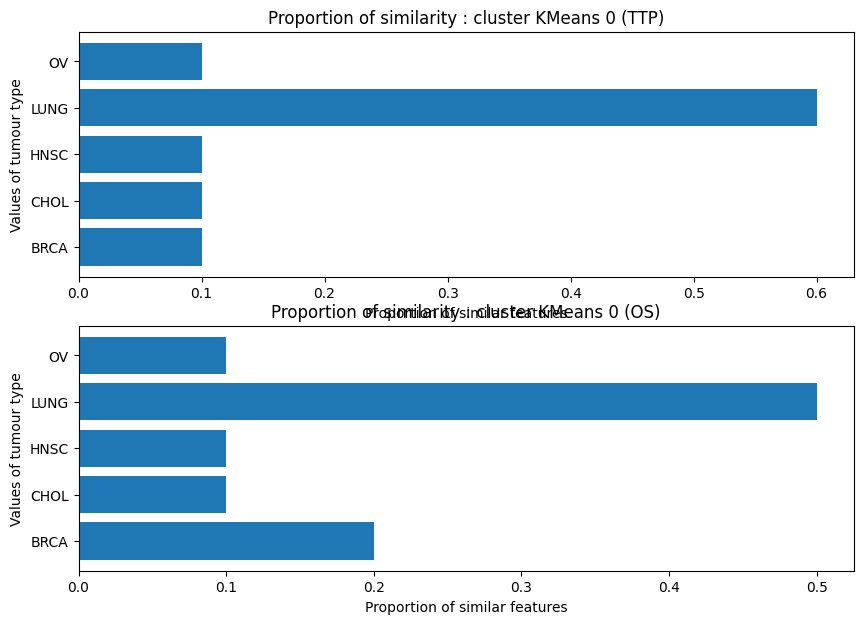

In [28]:
fig, ax = plt.subplots(2,1,figsize=(10,7))

## TTP :
ax[0].barh(values_counts_kmeans_ttp[0][0],values_counts_kmeans_ttp[0][1])
ax[0].set_xlabel("Proportion of similar features")
ax[0].set_ylabel("Values of tumour type")
ax[0].set_title("Proportion of similarity : cluster KMeans 0 (TTP)")

## OS :
ax[1].barh(values_counts_kmeans_os[0][0],values_counts_kmeans_os[0][1])
ax[1].set_xlabel("Proportion of similar features")
ax[1].set_ylabel("Values of tumour type")
ax[1].set_title("Proportion of similarity : cluster KMeans 0 (OS)")

##### Spectral clustering clusters

In [29]:
## TTP :
values_counts_spec_ttp = all_neighbours_features(G_spec_ttp, "Tumour type")

## OS :
values_counts_spec_os = all_neighbours_features(G_spec_os, "Tumour type")

Text(0.5, 1.0, 'Proportion of similarity : cluster Spectral 0 (OS)')

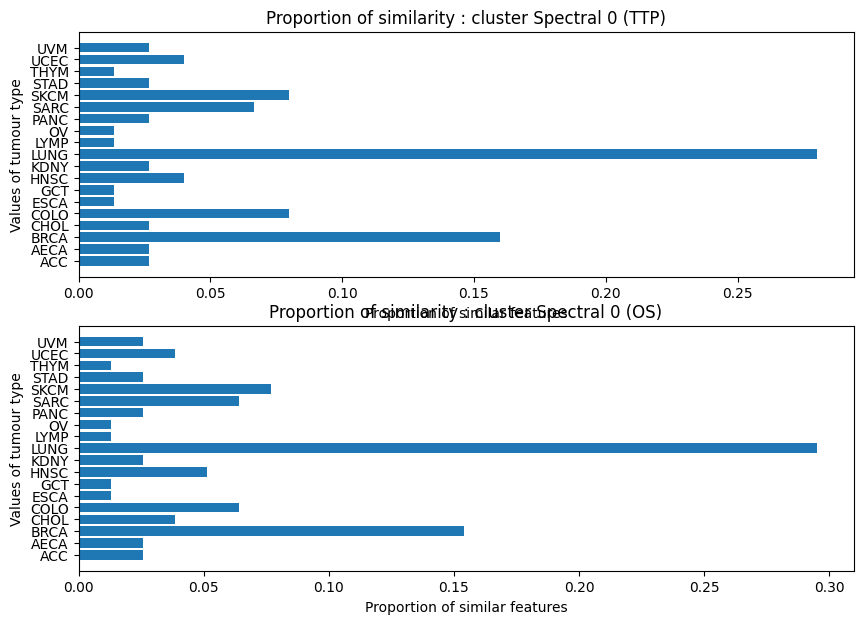

In [30]:
fig, ax = plt.subplots(2,1,figsize=(10,7))

## TTP :
ax[0].barh(values_counts_spec_ttp[0][0],values_counts_spec_ttp[0][1])
ax[0].set_xlabel("Proportion of similar features")
ax[0].set_ylabel("Values of tumour type")
ax[0].set_title("Proportion of similarity : cluster Spectral 0 (TTP)")

## OS :
ax[1].barh(values_counts_spec_os[0][0],values_counts_spec_os[0][1])
ax[1].set_xlabel("Proportion of similar features")
ax[1].set_ylabel("Values of tumour type")
ax[1].set_title("Proportion of similarity : cluster Spectral 0 (OS)")

##### Hierarchical clustering clusters

In [31]:
## TTP :
values_counts_hierarchical_ttp = all_neighbours_features(G_hierarchical_ttp, "Tumour type")

## OS :
values_counts_hierarchical_os = all_neighbours_features(G_hierarchical_os, "Tumour type")

Text(0.5, 1.0, 'Proportion of similarity : cluster Hierarchical 0 (OS)')

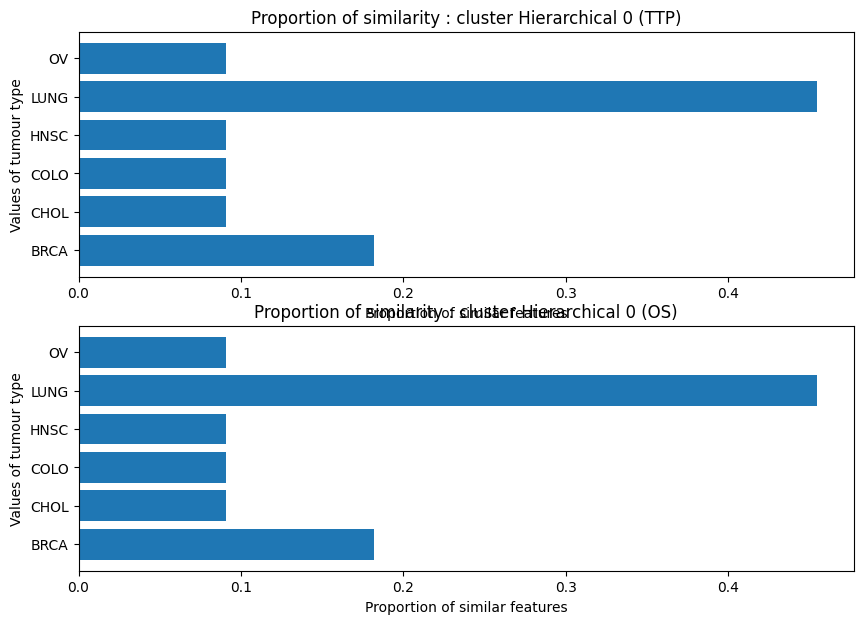

In [32]:
fig, ax = plt.subplots(2,1,figsize=(10,7))

## TTP :
ax[0].barh(values_counts_hierarchical_ttp[0][0],values_counts_hierarchical_ttp[0][1])
ax[0].set_xlabel("Proportion of similar features")
ax[0].set_ylabel("Values of tumour type")
ax[0].set_title("Proportion of similarity : cluster Hierarchical 0 (TTP)")

## OS :
ax[1].barh(values_counts_hierarchical_os[0][0],values_counts_hierarchical_os[0][1])
ax[1].set_xlabel("Proportion of similar features")
ax[1].set_ylabel("Values of tumour type")
ax[1].set_title("Proportion of similarity : cluster Hierarchical 0 (OS)")

## 3. Print number of distinct subgraphs <a name="print-n-subgraphs"></a>

## 4. Print number of neighbours per node